<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


## Importing the packages


In [194]:

#!pip install eikon

import eikon as ek
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import importlib
import matplotlib.pyplot as plt

import plotting_functions as mp
import analytical_functions as af

importlib.reload(af)


<module 'analytical_functions' from 'c:\\Users\\paolo\\OneDrive\\Desktop\\SF_Project\\stochastic-finance-project\\analytical_functions.py'>

## Retrieving the data

In [195]:
# Setting up the API key
ek.set_app_key('6e2b6a629eb84c0b859dc5faf22d48f94d85de97')

#### Search parameters


In [196]:
fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot',
            'TR.CommonName', 'TR.NAICSSector']

start_date = '2024-12-30'

end_date = '2018-12-30'

rolling_window = 252

### Getting different groups of stocks based on their leverage ratio

We will use, at this stage, as a proxy of the value of the assets the sum of the market capitalization of a given firmi and the firm's total debt

In [197]:
#This will get all the stocks in the S&P 500 data_cross for the specified fields
data_cross, err = ek.get_data(instruments=['0#.SPX'], fields = fields)
data_cross.head()

number = data_cross.shape[0]

#Excluding financial sector
data_cross = data_cross[data_cross['NAICS Sector Name'] != 'Finance and Insurance']
post_number = data_cross.shape[0]

print(f'Removed {number - post_number} companies, for a total of {data_cross.shape[0]} companies')

Removed 68 companies, for a total of 435 companies


c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [199]:
data_cross['Equity Value'] = data_cross['Close Price'] * data_cross['Shares used to calculate Diluted EPS - Total']

data_cross['Asset Value'] = data_cross['Equity Value'] + data_cross['Debt - Total']

data_cross['Leverage Ratio'] = data_cross['Debt - Total'] / data_cross['Asset Value']

data_cross = data_cross.sort_values(by = 'Leverage Ratio', ascending= False)

data_cross = data_cross.dropna(subset=['Leverage Ratio'])

print(data_cross.head())

    Instrument                  Date  Close Price  \
162        F.N  2025-01-03T00:00:00Z         9.88   
346     CZR.OQ  2025-01-03T00:00:00Z        32.51   
283      AES.N  2025-01-03T00:00:00Z        13.23   
341    PARA.OQ  2025-01-03T00:00:00Z        10.67   
58        CE.N  2025-01-03T00:00:00Z        66.13   

     Shares used to calculate Diluted EPS - Total  Market Capitalization  \
162                                  4041000000.0     48096718461.658302   
346                                   216000000.0         10092789246.24   
283                                   712000000.0         12890358923.75   
341                                   652000000.0          9828030434.42   
58                                    109379664.0     16912370353.620001   

       Debt - Total        Company Common Name  \
162  149231000000.0              Ford Motor Co   
346   25048000000.0  Caesars Entertainment Inc   
283   26878000000.0                   AES Corp   
341   14602000000.0     

In [200]:
print(data_cross[['Company Common Name', 'Leverage Ratio']].head(100))

           Company Common Name  Leverage Ratio
162              Ford Motor Co         0.78893
346  Caesars Entertainment Inc        0.781038
283                   AES Corp        0.740486
341           Paramount Global        0.677309
58               Celanese Corp        0.654196
..                         ...             ...
382                   LKQ Corp        0.302173
277        Dollar General Corp         0.29886
383            Bunge Global SA        0.295254
363                    UDR Inc        0.290276
111  Occidental Petroleum Corp        0.289104

[100 rows x 2 columns]


### Clustering the stocks based on their leverage ratio

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans 

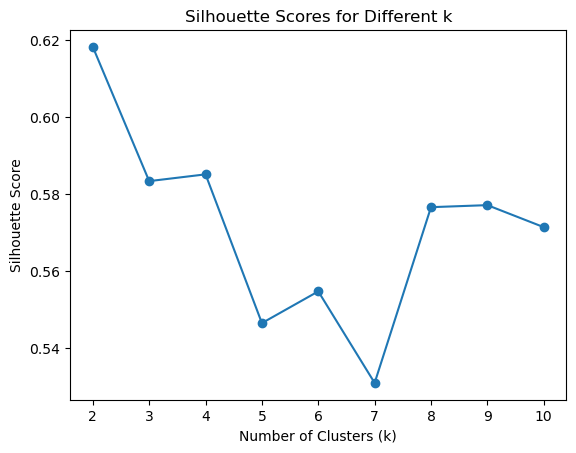

In [201]:
# Cluster them

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



scaler = MinMaxScaler()
data_cross['leverage_ratio_normalized'] = scaler.fit_transform(data_cross[['Leverage Ratio']])

silhouette_scores = []
for k in range(2, 11):  # Start from 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_cross[['leverage_ratio_normalized']])
    silhouette_scores.append(silhouette_score(data_cross[['leverage_ratio_normalized']], labels))

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [202]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(data_cross[['leverage_ratio_normalized']])
# Add cluster labels to the data_crossFrame
data_cross['cluster'] = labels
cluster_means = data_cross.groupby('cluster')['Leverage Ratio'].mean()

ranked_clusters = cluster_means.sort_values(ascending=False).rank(ascending=False).astype(int)

# Step 3: Map ranked cluster numbers back to the data_crossFrame
ranked_mapping = {cluster: rank for cluster, rank in zip(cluster_means.sort_values(ascending=False).index, ranked_clusters)}
data_cross['ranked_cluster'] = data_cross['cluster'].map(ranked_mapping)

print(data_cross[['Leverage Ratio', 'cluster', 'ranked_cluster']])

print('\nThe companies for each cluster are:')
data_cross['ranked_cluster'].value_counts()


     Leverage Ratio  cluster  ranked_cluster
162         0.78893        2               1
346        0.781038        2               1
283        0.740486        2               1
341        0.677309        2               1
58         0.654196        2               1
..              ...      ...             ...
151             0.0        1               4
225             0.0        1               4
113             0.0        1               4
89              0.0        1               4
146             0.0        1               4

[429 rows x 3 columns]

The companies for each cluster are:


c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


ranked_cluster
4    184
3    139
2     76
1     30
Name: count, dtype: int64

In [203]:
# Sample 5 companies from each cluster
sampled_data = data_cross.groupby('ranked_cluster').apply(lambda x: x.sample(n=5, random_state=42))

# Reset index to make it easier to work with
sampled_data = sampled_data.reset_index(drop=True)

print(sampled_data.sort_values(by = 'Leverage Ratio', ascending = False))

   Instrument                  Date  Close Price  \
4       KMX.N  2025-01-03T00:00:00Z        80.07   
1     VTRS.OQ  2025-01-03T00:00:00Z        12.28   
3       EIX.N  2025-01-03T00:00:00Z         79.8   
2     EVRG.OQ  2025-01-03T00:00:00Z        61.55   
0      AEP.OQ  2025-01-03T00:00:00Z        92.05   
8         T.N  2025-01-03T00:00:00Z        22.67   
5        ED.N  2025-01-03T00:00:00Z        89.24   
7        SO.N  2025-01-03T00:00:00Z        82.32   
6       DAL.N  2025-01-03T00:00:00Z         59.0   
9      AMCR.N  2025-01-03T00:00:00Z         9.33   
12    FOXA.OQ  2025-01-03T00:00:00Z        49.32   
14      NEM.N  2025-01-03T00:00:00Z        38.11   
11       PM.N  2025-01-03T00:00:00Z       122.02   
13      BFb.N  2025-01-03T00:00:00Z        36.25   
10     GNRC.N  2025-01-03T00:00:00Z       158.88   
15      DOV.N  2025-01-03T00:00:00Z       188.03   
16    ZBRA.OQ  2025-01-03T00:00:00Z       391.86   
18      EOG.N  2025-01-03T00:00:00Z       126.57   
19    PANW.O

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\3920466248.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data_cross.groupby('ranked_cluster').apply(lambda x: x.sample(n=5, random_state=42))


In [204]:
random_sample = list(sampled_data['Instrument'])

print(random_sample)

['AEP.OQ', 'VTRS.OQ', 'EVRG.OQ', 'EIX.N', 'KMX.N', 'ED.N', 'DAL.N', 'SO.N', 'T.N', 'AMCR.N', 'GNRC.N', 'PM.N', 'FOXA.OQ', 'BFb.N', 'NEM.N', 'DOV.N', 'ZBRA.OQ', 'WST.N', 'EOG.N', 'PANW.OQ']


In [205]:
#Setting up the function


def get_financial_data(rics, fields, 
                       start_date, end_date,
                       rolling_window):
    #rics = rics
    #Data fields we are interested in: 
      #Total value of equity
      #Total value of debt

    results = []

    df = pd.DataFrame()

    for ric in rics:
        data, err = ek.get_data([ric], fields,
                                {'SDate': f'{start_date}' , 'EDate': f'{end_date}', 'FRQ':'D','period':'FY0'}) #Not sure about period
        if err is None:
            data['RIC'] = ric
            results.append(data)
        else:
            print(f"Error retrieving data for {ric}: {err}")
        
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values(by='Date').reset_index(drop=True)

        data['Equity_Value'] = data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']

        
        #Computing the log-returns
        prices = data['Close Price']
        log_returns = np.log(prices / prices.shift(1)).dropna()
        data['Log_Returns'] = log_returns
        data.dropna()

        #Compute the rolling-window estimation of the volatility using last year observations
        data['Rolling_Volatility'] = (data['Log_Returns'].rolling(window=rolling_window).std() * np.sqrt(rolling_window) )
        #data['Rolling_Volatility'] = data['Log_Returns'].std() * np.sqrt(252)
        data = data.dropna(subset=['Rolling_Volatility'])
        data = data.dropna(how = 'any')
        


        #Computing total asset values as a sum of the market capitalization + total debt
        #data['Total_value'] = data['Market Capitalization'] + data['Debt - Total']
        data['Total_value'] = (data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']) + data['Debt - Total']
        
        
        data = data.set_index(['Instrument', 'Date'])

    #Combine results into a single DataFrame
        df = pd.concat([df, data])
    #df.drop(columns=['RIC'])

    #Add Total asset value column
    

    return df


#### Choosing the stocks

In [206]:
random = False
if not random:

    rics_list = ['AEP.OQ', 'VTRS.OQ', 'EVRG.OQ', 'EIX.N', 'KMX.N', 'ED.N', 'DAL.N', 'SO.N', 'T.N', 'AMCR.N', 'GNRC.N', 
                'PM.N', 'FOXA.OQ', 'BFb.N', 'NEM.N', 'DOV.N', 'ZBRA.OQ', 'WST.N', 'EOG.N', 'PANW.OQ']
    
else:

    rics_list = random_sample

In [207]:
removing_fields = ['TR.CommonName', 'TR.NAICSSector']

fields = [i for i in fields if i not in removing_fields]

#### Retrieving the data

In [208]:
data = get_financial_data(rics_list, fields,
                          start_date, end_date,
                          252)

print(data.head())

print('-'*100)

print(data.tail())

print('-'*100)
#Checks on single stocks
print(data.loc[rics_list[0]].head())

print('-')
print(data.loc[rics_list[1]].describe())

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:10

                                      Close Price  \
Instrument Date                                     
AEP.OQ     2019-12-31 00:00:00+00:00        94.51   
           2020-01-02 00:00:00+00:00        93.46   
           2020-01-03 00:00:00+00:00        93.36   
           2020-01-06 00:00:00+00:00        93.67   
           2020-01-07 00:00:00+00:00        93.69   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AEP.OQ     2019-12-31 00:00:00+00:00                                   493758277.0   
           2020-01-02 00:00:00+00:00                                   493758277.0   
           2020-01-03 00:00:00+00:00                                   493758277.0   
           2020-01-06 00:00:00+00:00                                   493758277.0   
           2020-01-07 00:00:00+00:00                                   493758277.0   

                         

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [213]:
# Creating a RICS dictionary

index = data.index
unique_instruments = index.get_level_values('Instrument').unique()
print(unique_instruments)
print(len(unique_instruments))

unique_names = []

for ric in unique_instruments:

    row = data_cross[data_cross['Instrument'] == ric]
    
    name = row['Company Common Name'].iloc[0]
    unique_names.append(name)


print(unique_names)
#rics_dict = {key, value for key,value in unique_values}

rics_dict = {key:value for key,value in zip(unique_instruments, unique_names)}

Index(['AEP.OQ', 'VTRS.OQ', 'EVRG.OQ', 'EIX.N', 'KMX.N', 'ED.N', 'DAL.N',
       'SO.N', 'T.N', 'AMCR.N', 'GNRC.N', 'PM.N', 'FOXA.OQ', 'BFb.N', 'NEM.N',
       'DOV.N', 'ZBRA.OQ', 'WST.N', 'EOG.N', 'PANW.OQ'],
      dtype='string', name='Instrument')
20
['American Electric Power Company Inc', 'Viatris Inc', 'Evergy Inc', 'Edison International', 'Carmax Inc', 'Consolidated Edison Inc', 'Delta Air Lines Inc', 'Southern Co', 'AT&T Inc', 'Amcor PLC', 'Generac Holdings Inc', 'Philip Morris International Inc', 'Fox Corp', 'Brown-Forman Corp', 'Newmont Corporation', 'Dover Corp', 'Zebra Technologies Corp', 'West Pharmaceutical Services Inc', 'EOG Resources Inc', 'Palo Alto Networks Inc']


In [60]:
# import pickle
# import sys
# import os

# current_directory = os.getcwd()

# # Add the current working directory to sys.path
# if current_directory not in sys.path:
#     sys.path.append(current_directory)
#     print('Yes')


# with open('dataframe.pkl', mode= 'rb') as f:

#     data = pickle.load(f)

## Computing the value of the asset and its volatility

In [62]:
# df_k = pd.DataFrame()

# for ric in rics_list:
#     df = data.loc[ric]
#     df = df.reset_index()
#     df['Total_value'] = (df['Close Price'] * df['Shares used to calculate Diluted EPS - Total']) +df['Debt - Total']
#     # Compute log returns and rolling volatility
#     df['Log_Returns'] = np.log(df['Close Price'] / df['Close Price'].shift(1))
#     df['Rolling_Volatility'] = df['Log_Returns'].rolling(window=252).std() 
#     df = df.dropna(subset=['Rolling_Volatility'])
    
#     # Compute total asset value (equity + debt)
#     #df['Total_value'] = df['Market Capitalization'] + df['Debt - Total']
#     df['RIC'] = ric
#     df = df.set_index([f'RIC', 'Date'])
#     df = df.dropna(how='any')

#     # Drop rows with missing data
    

#     df_k = pd.concat([df, df_k])

# data = df_k.copy()

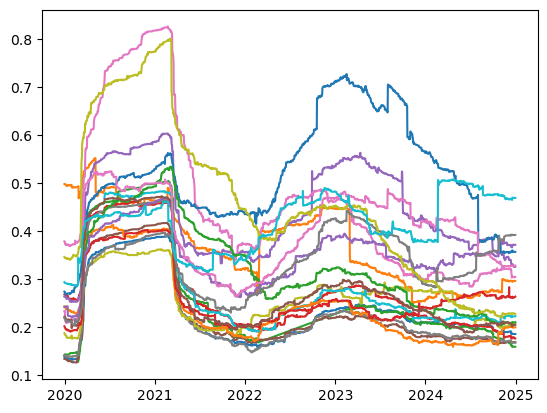

In [214]:
for ric in rics_list:

    plt.plot(data.loc[ric]['Rolling_Volatility'])

In [215]:
# Solve the system for each row
def solve_system(row):
    # Extract parameters from the row
    E = row['Close Price'] * row['Shares used to calculate Diluted EPS - Total'] # Equity (market capitalization)
    sigma_E = row['Rolling_Volatility']  # Rolling volatility as initial guess for sigma_A
    D = row['Debt - Total']          # Debt
    
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']        # Assume a risk-free rate column
    
    T = 1                            # Time to maturity (1 year)
    t = 0                            # Current time

    # Define the system of equations
    def system(vars):
        if D > 0:
            A, sigma_A = vars  # Unknowns: Asset value and asset volatility
            equity_value = af.merton_equity(A, D, r, sigma_A, T, t)
            d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
            f1 = equity_value - E  # Equation (2)
            f2 = (A / E) * norm.cdf(d1) * sigma_A - sigma_E  # Equation (4)

        else: 

            f1 = E 
            f2 = sigma_E
        return [f1, f2]

    # Initial guesses
    A_guess = row['Total_value']  # Total value (equity + debt)
    sigma_A_guess = row['Rolling_Volatility']  # Rolling volatility

    # Solve the system
    solution = fsolve(system, [A_guess, sigma_A_guess])
    return pd.Series({'A_solution': solution[0], 'sigma_A_solution': solution[1]})

# Apply the solver to the DataFrame
def solve_for_all(df):
    results = df.apply(solve_system, axis=1)
    return pd.concat([df, results], axis=1)


In [216]:
data.isna().sum()

Close Price                                     0
Shares used to calculate Diluted EPS - Total    0
Market Capitalization                           0
Debt - Total                                    0
RIC                                             0
Equity_Value                                    0
Log_Returns                                     0
Rolling_Volatility                              0
Total_value                                     0
dtype: int64

In [ ]:
#Computing the asset value and volatility at each point in time

#For 20 companies it should take approximately 1 min 
df_with_solutions = solve_for_all(data)
print(df_with_solutions.head())

                                      Close Price  \
Instrument Date                                     
AEP.OQ     2019-12-31 00:00:00+00:00        94.51   
           2020-01-02 00:00:00+00:00        93.46   
           2020-01-03 00:00:00+00:00        93.36   
           2020-01-06 00:00:00+00:00        93.67   
           2020-01-07 00:00:00+00:00        93.69   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AEP.OQ     2019-12-31 00:00:00+00:00                                   493758277.0   
           2020-01-02 00:00:00+00:00                                   493758277.0   
           2020-01-03 00:00:00+00:00                                   493758277.0   
           2020-01-06 00:00:00+00:00                                   493758277.0   
           2020-01-07 00:00:00+00:00                                   493758277.0   

                         

In [218]:
df_with_solutions.columns

Index(['Close Price', 'Shares used to calculate Diluted EPS - Total',
       'Market Capitalization', 'Debt - Total', 'RIC', 'Equity_Value',
       'Log_Returns', 'Rolling_Volatility', 'Total_value', 'A_solution',
       'sigma_A_solution'],
      dtype='object')

In [219]:
#Adding leverage ration

df_with_solutions['Leverage_Ratio'] = df_with_solutions['Debt - Total'] / df_with_solutions['A_solution']

## Computing the relevant quantities of the Merton's model

In [220]:
def compute_additional_metrics(row):
    # Extract inputs from the row
    """
    V = row['Total_value']  # Asset value
    sigma = row['Rolling_Volatility']  # Asset volatility
    """
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.01
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    #M = 1_000_000

    # Compute quantities using the provided functions
    equity_value = af.merton_equity(V, K, r, sigma, T, t)
    debt_value = af.merton_debt(V, K, r, sigma, T, t)
    default_probability = af.default_probability(V, K, r, sigma, T, t)
    #mc_default_probability = af.monte_carlo_merton_2(V, K, r, sigma, T, M)
    # mc_sim = af.monte_carlo_merton_2(V, K, r, sigma, T, M)
    # mc_default_probability = mc_sim[2]
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)
    #credit_spread_2 = af.credit_spread_model_new(V, K, sigma, r, T, t)


    # Return results as a Series
    return pd.Series({
        'Merton_Equity_Value': equity_value,
        'Merton_Debt_Value': debt_value,
        'Default_Probability': default_probability,
        #'MC_Default_Probability': mc_default_probability,
        'Credit_Spread': credit_spread
        
    })
#'Credit_Spread_2': credit_spread_2

In [221]:
importlib.reload(af)

#Compute the equity value, debt value and probability of default for each company and at each date
#For 20 companies it should take approximately 40 sec
df_with_metrics = df_with_solutions.apply(compute_additional_metrics, axis=1)

#Combine the quantities results with the original dataframe
df_final = pd.concat([df_with_solutions, df_with_metrics], axis=1)

#### Plotting the probability of default through time

<Figure size 1000x600 with 0 Axes>

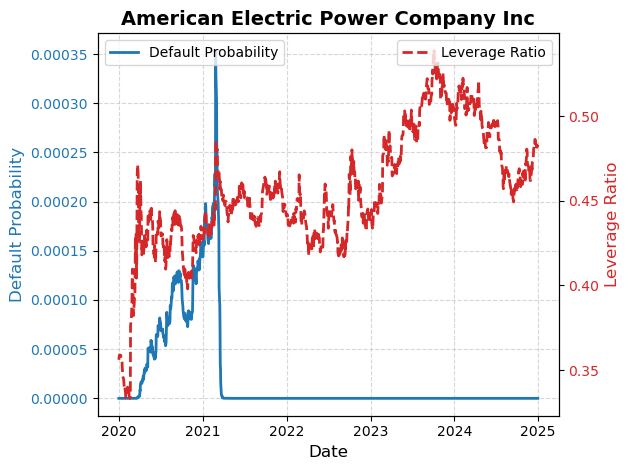

<Figure size 1000x600 with 0 Axes>

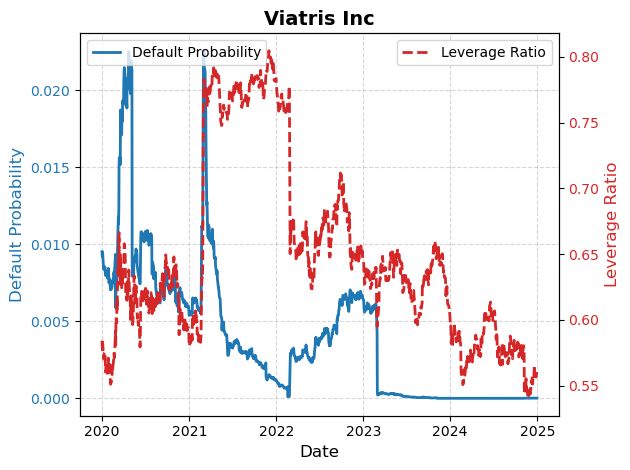

<Figure size 1000x600 with 0 Axes>

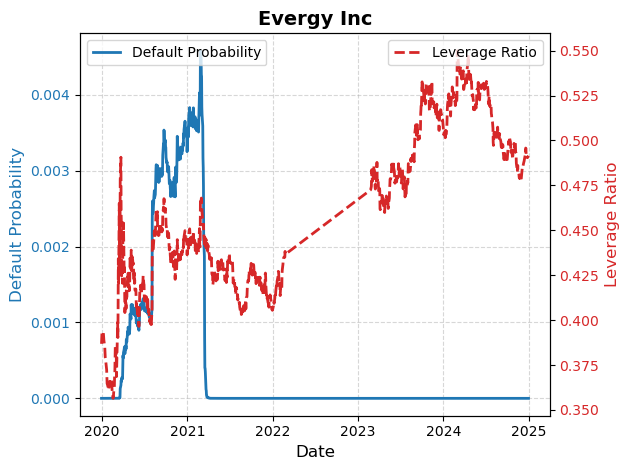

<Figure size 1000x600 with 0 Axes>

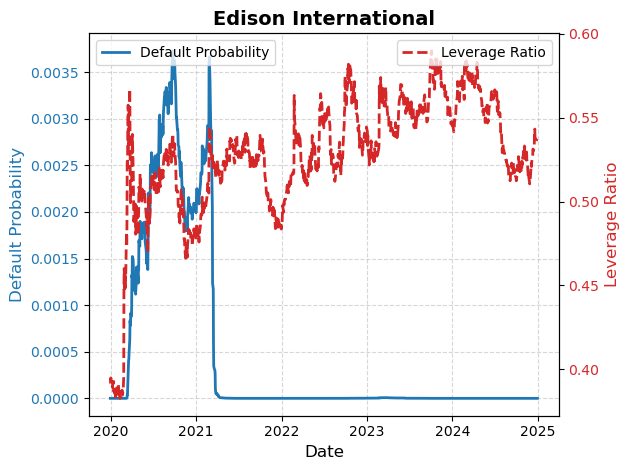

<Figure size 1000x600 with 0 Axes>

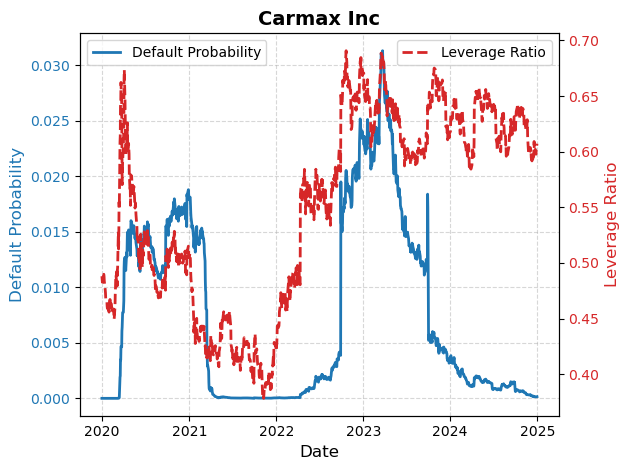

<Figure size 1000x600 with 0 Axes>

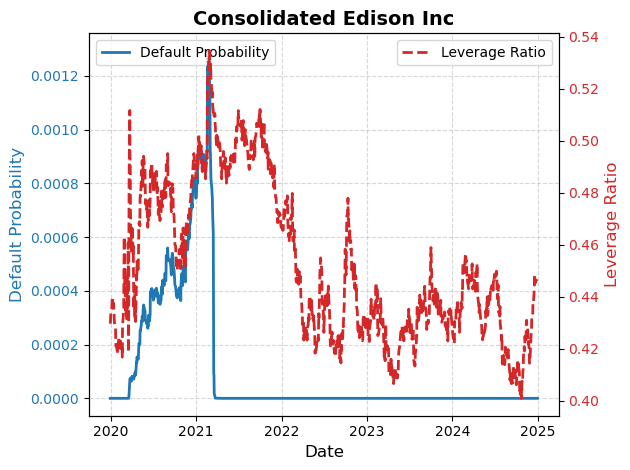

<Figure size 1000x600 with 0 Axes>

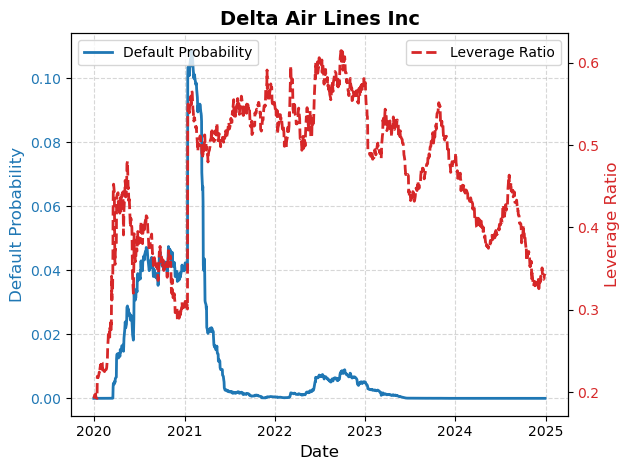

<Figure size 1000x600 with 0 Axes>

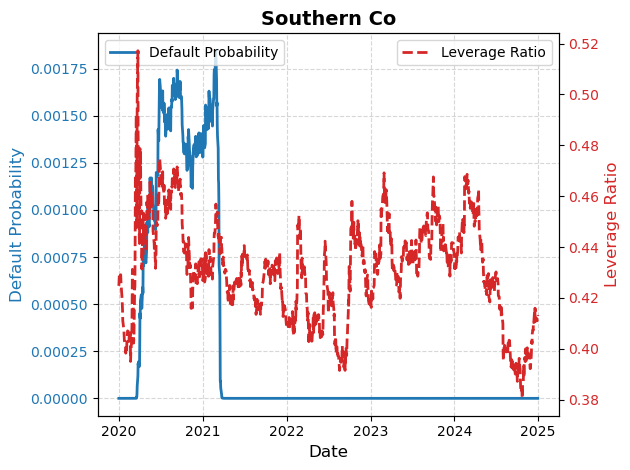

<Figure size 1000x600 with 0 Axes>

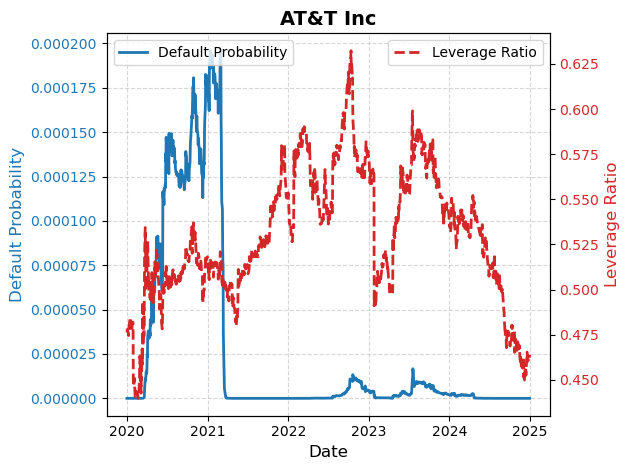

<Figure size 1000x600 with 0 Axes>

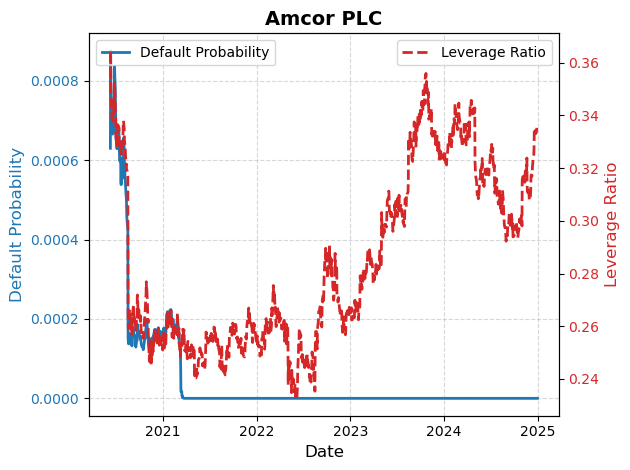

<Figure size 1000x600 with 0 Axes>

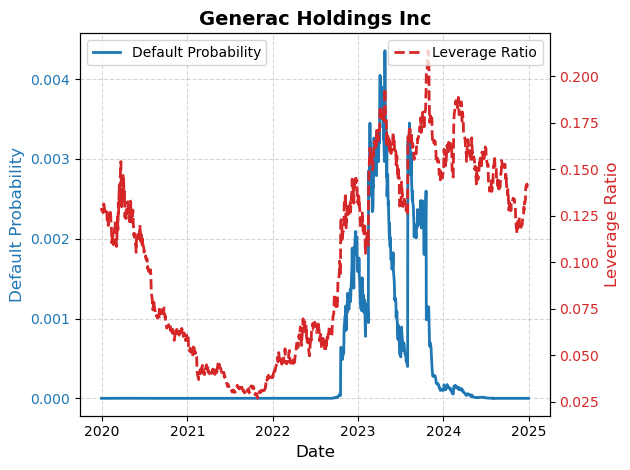

<Figure size 1000x600 with 0 Axes>

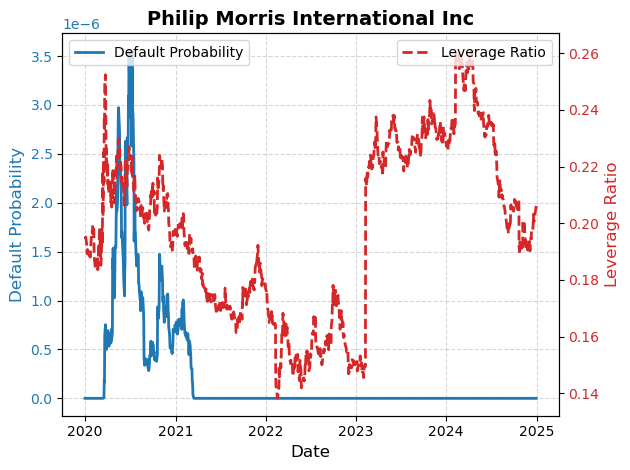

<Figure size 1000x600 with 0 Axes>

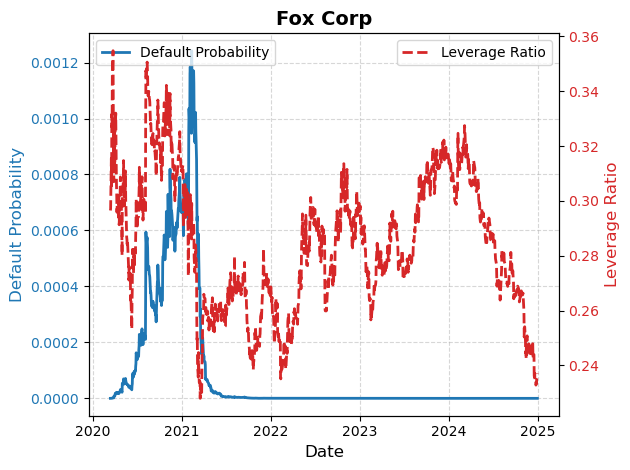

<Figure size 1000x600 with 0 Axes>

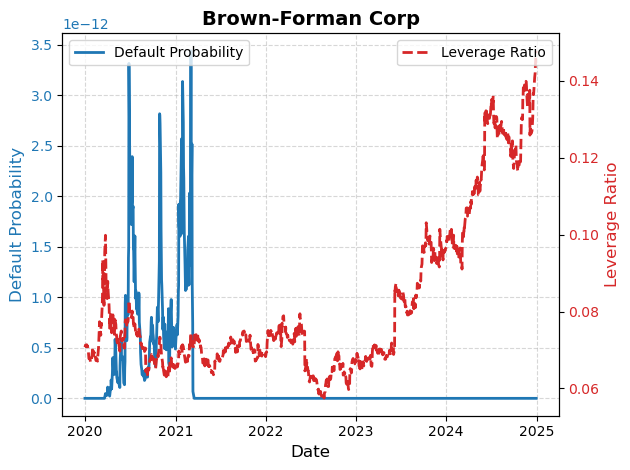

<Figure size 1000x600 with 0 Axes>

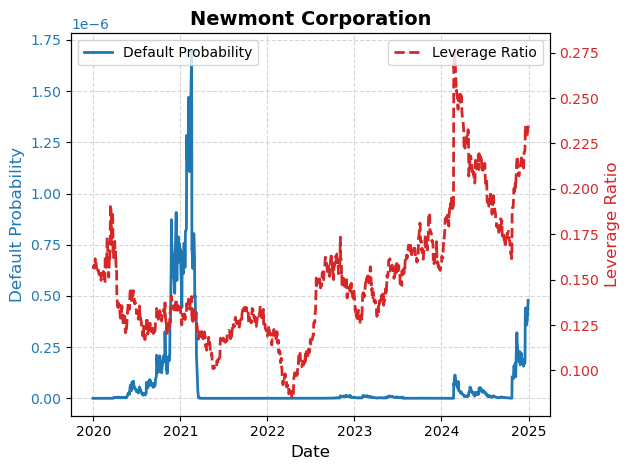

<Figure size 1000x600 with 0 Axes>

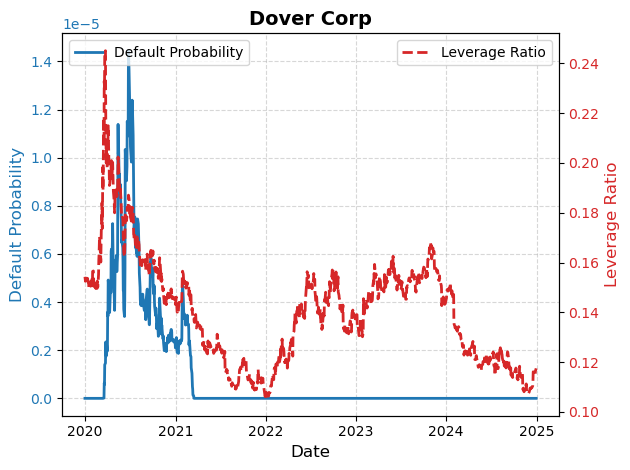

<Figure size 1000x600 with 0 Axes>

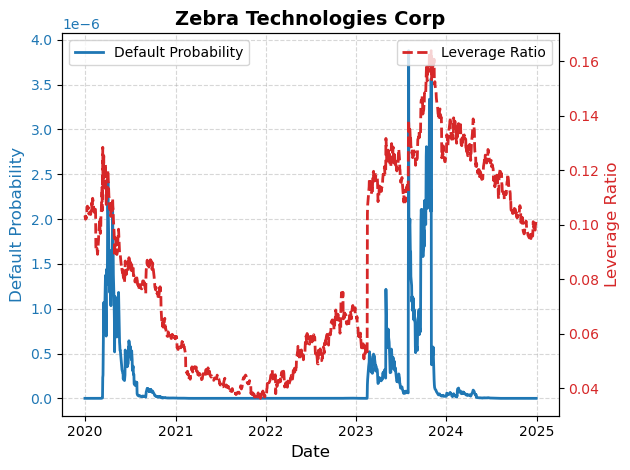

<Figure size 1000x600 with 0 Axes>

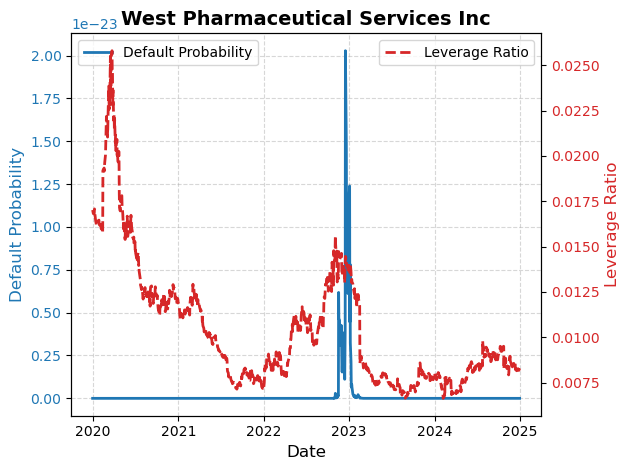

<Figure size 1000x600 with 0 Axes>

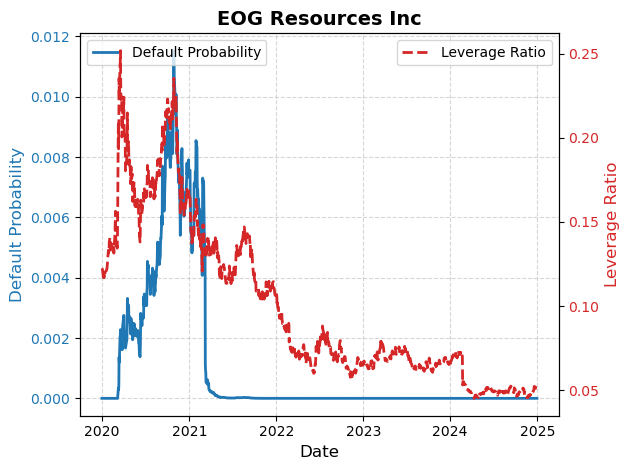

<Figure size 1000x600 with 0 Axes>

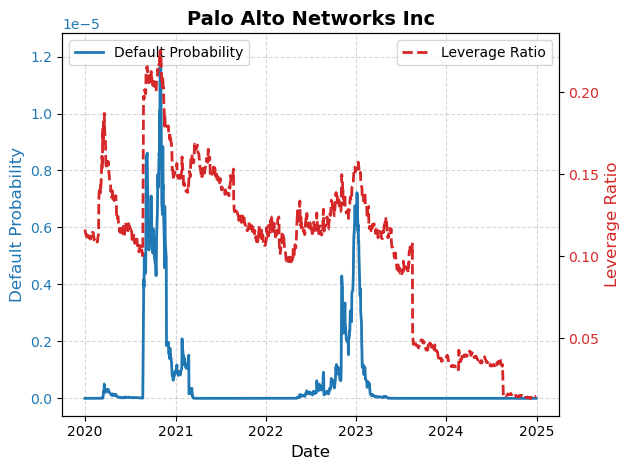

In [224]:
for ric in rics_list:
    plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization

    # Extract data
    def_probab = df_final.loc[ric]['Default_Probability']
    leverage_ratio = df_final.loc[ric]['Leverage_Ratio']

    # Create the main axis
    fig, ax1 = plt.subplots()

    # Plot Default Probability on the primary y-axis
    color1 = 'tab:blue'
    ax1.plot(def_probab, color=color1, label='Default Probability', linewidth=2)
    ax1.set_ylabel('Default Probability', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(leverage_ratio, color=color2, label='Leverage Ratio', linewidth=2, linestyle='dashed')
    ax2.set_ylabel('Leverage Ratio', color=color2, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    # Add title and legend
    plt.title(f'{rics_dict[ric]}', fontsize=14, fontweight='bold')
    fig.tight_layout()  # Adjust layout to prevent overlap
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()

<Figure size 1000x600 with 0 Axes>

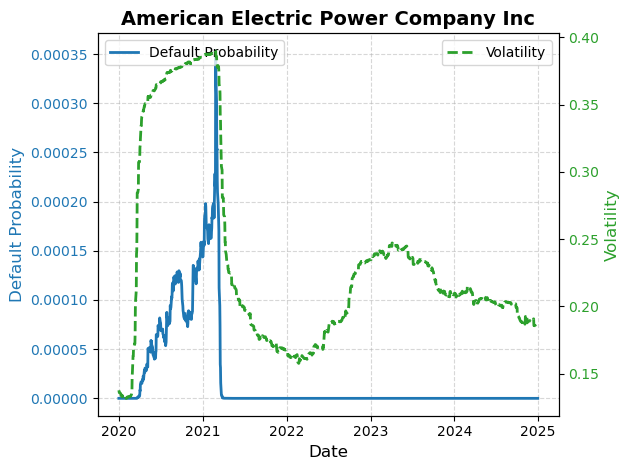

<Figure size 1000x600 with 0 Axes>

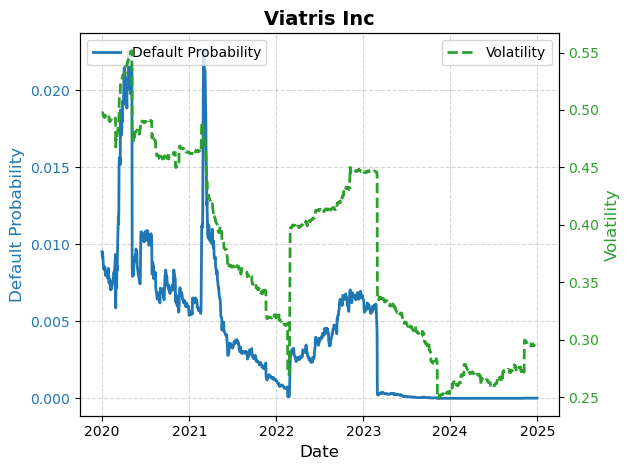

<Figure size 1000x600 with 0 Axes>

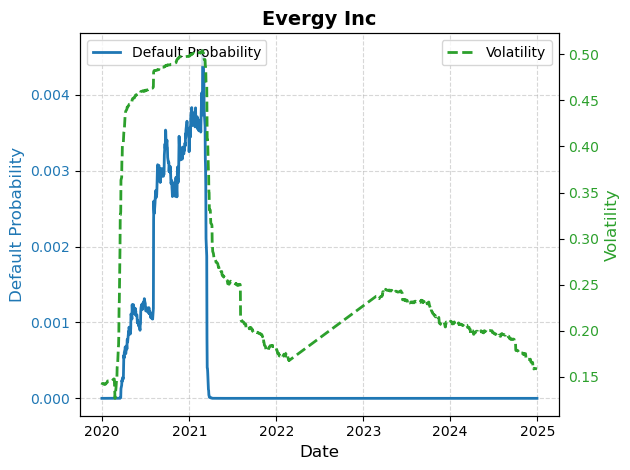

<Figure size 1000x600 with 0 Axes>

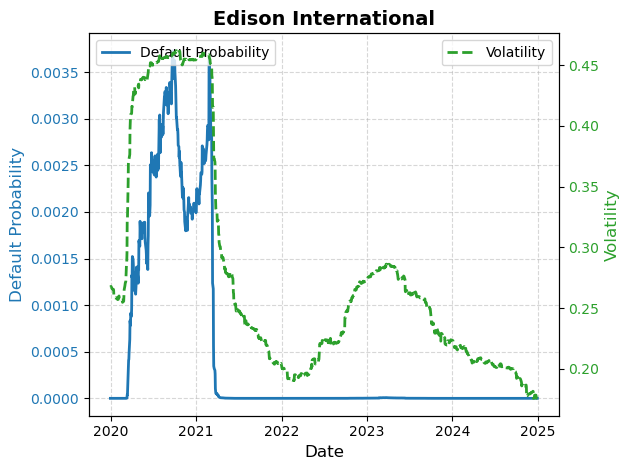

<Figure size 1000x600 with 0 Axes>

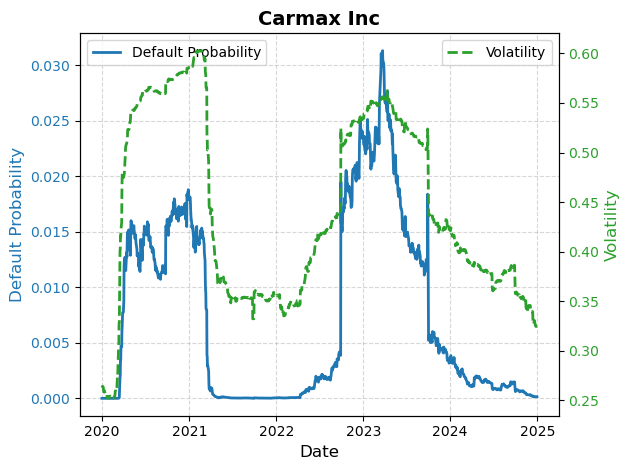

<Figure size 1000x600 with 0 Axes>

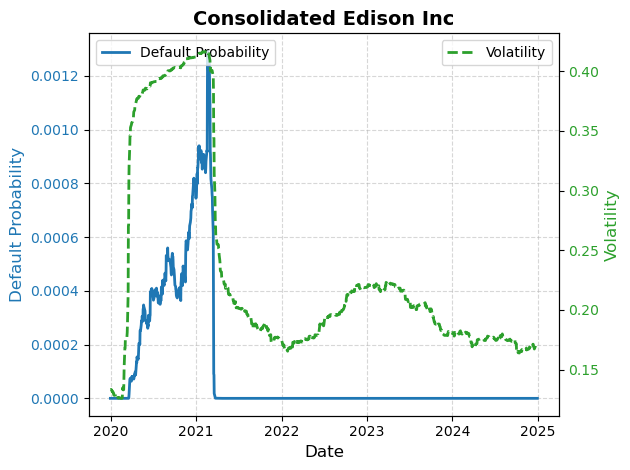

<Figure size 1000x600 with 0 Axes>

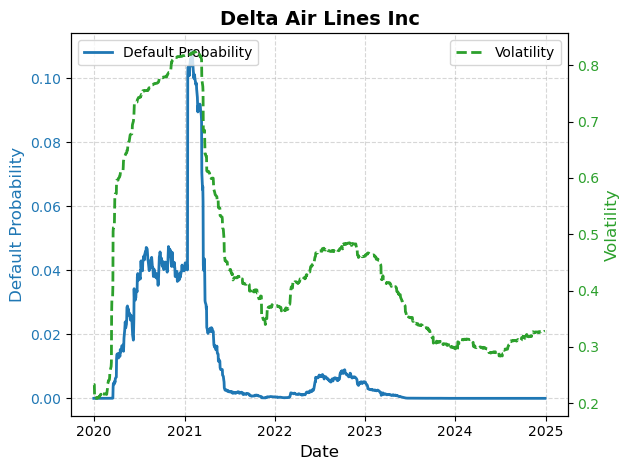

<Figure size 1000x600 with 0 Axes>

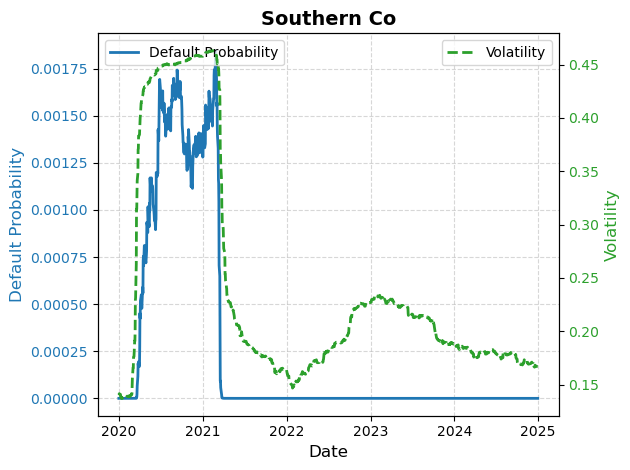

<Figure size 1000x600 with 0 Axes>

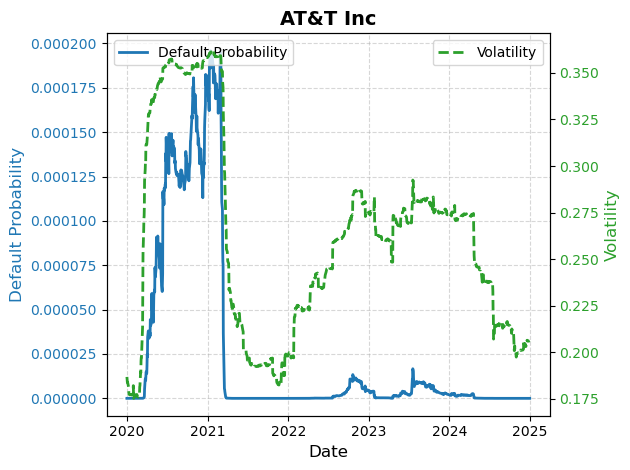

<Figure size 1000x600 with 0 Axes>

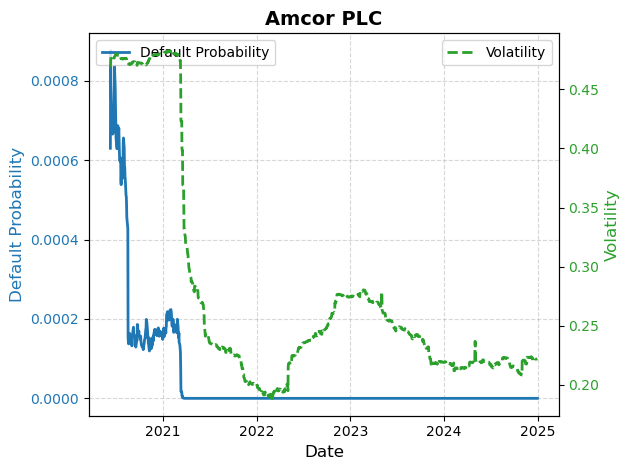

<Figure size 1000x600 with 0 Axes>

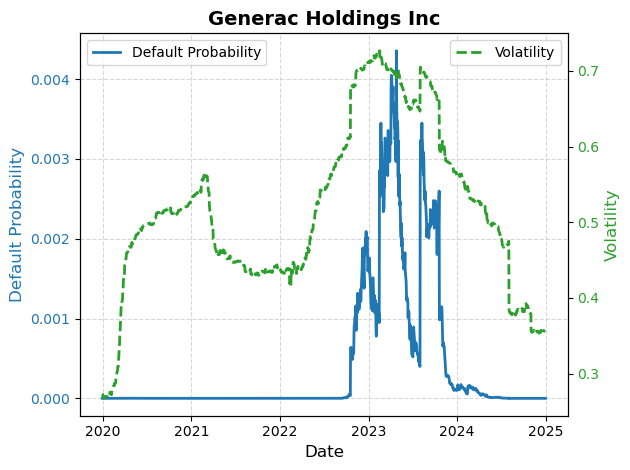

<Figure size 1000x600 with 0 Axes>

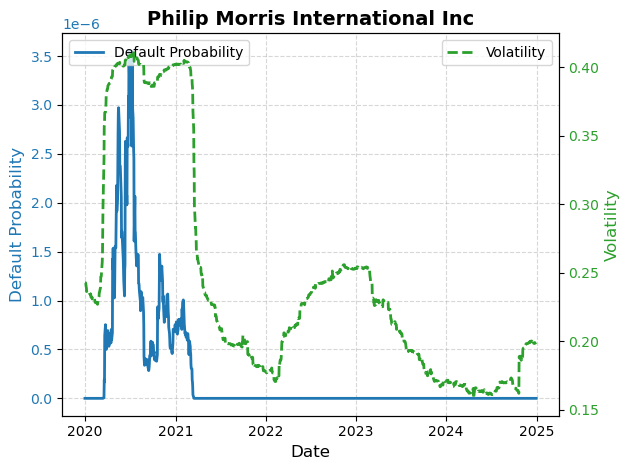

<Figure size 1000x600 with 0 Axes>

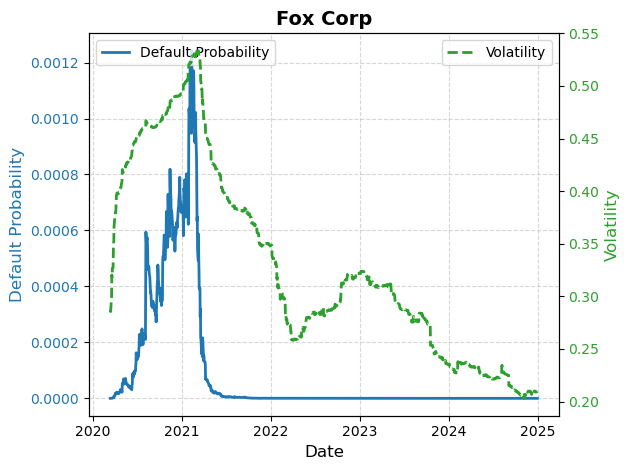

<Figure size 1000x600 with 0 Axes>

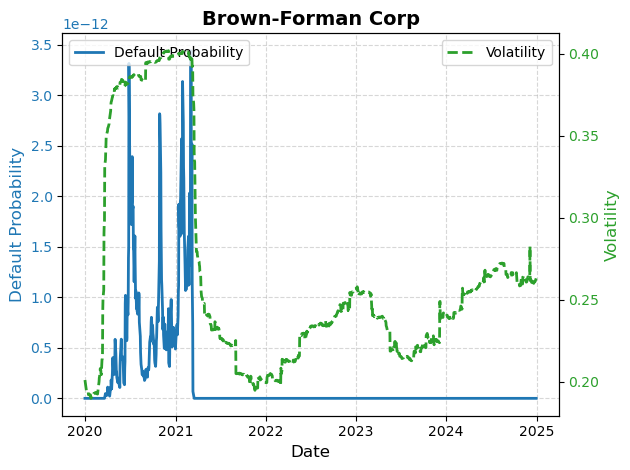

<Figure size 1000x600 with 0 Axes>

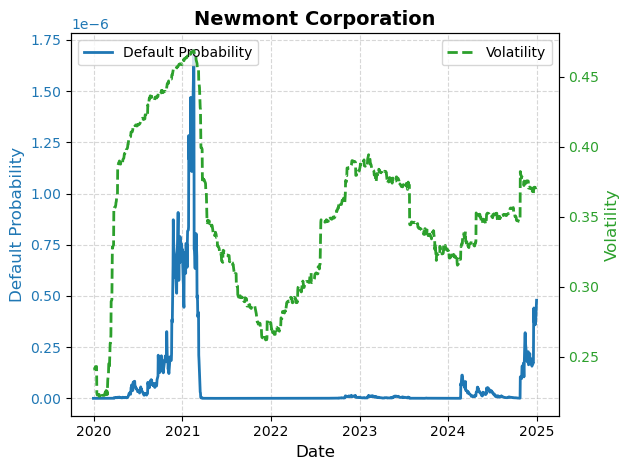

<Figure size 1000x600 with 0 Axes>

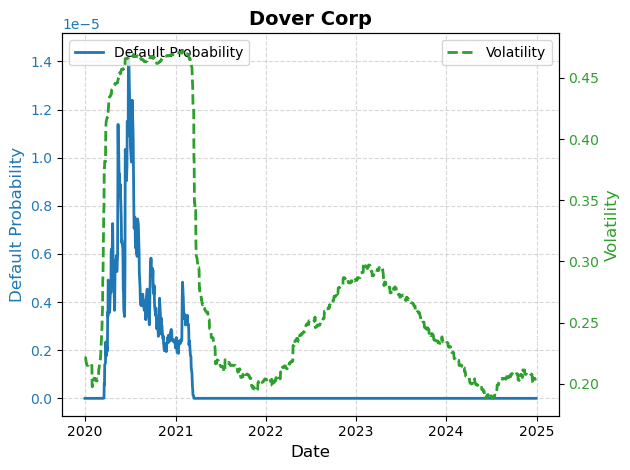

<Figure size 1000x600 with 0 Axes>

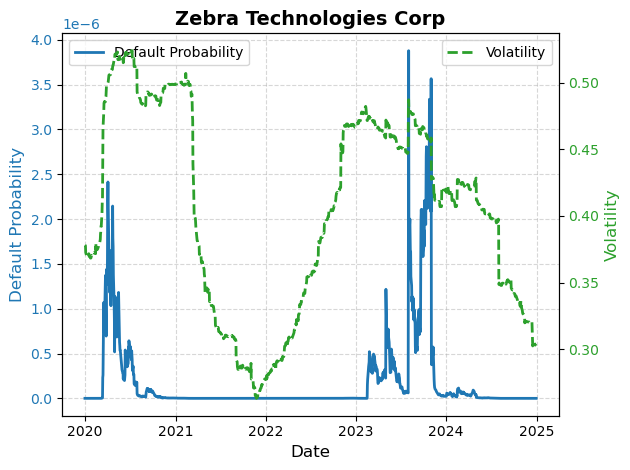

<Figure size 1000x600 with 0 Axes>

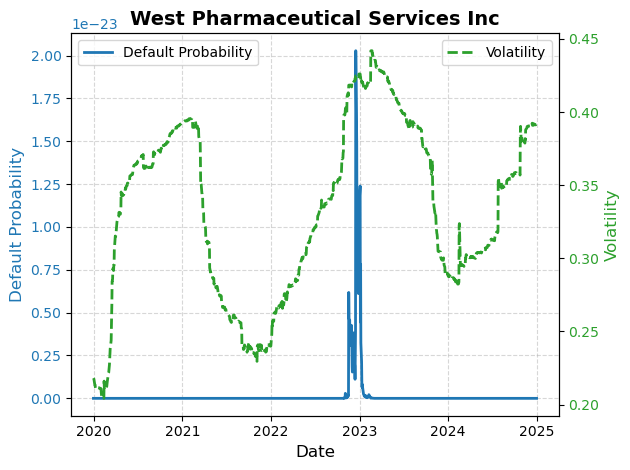

<Figure size 1000x600 with 0 Axes>

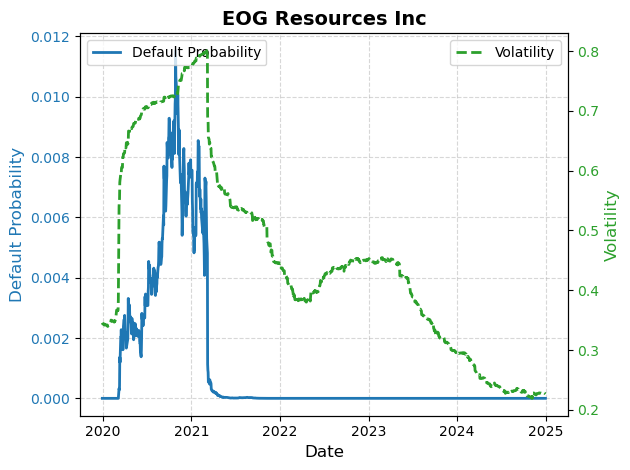

<Figure size 1000x600 with 0 Axes>

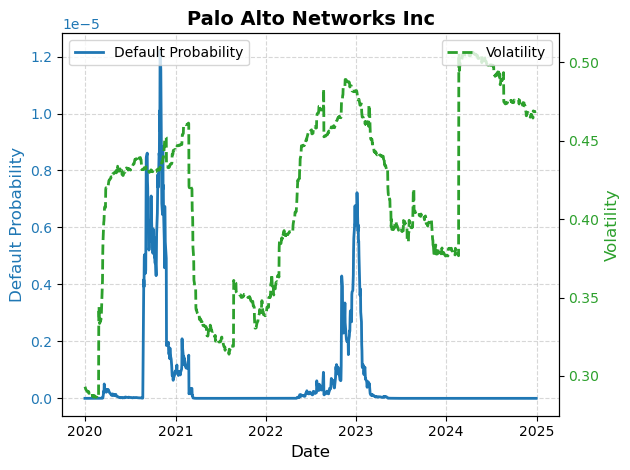

In [225]:
for ric in rics_list:
    plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization

    # Extract data
    def_probab = df_final.loc[ric]['Default_Probability']
    leverage_ratio = df_final.loc[ric]['Rolling_Volatility']

    # Create the main axis
    fig, ax1 = plt.subplots()

    # Plot Default Probability on the primary y-axis
    color1 = 'tab:blue'
    ax1.plot(def_probab, color=color1, label='Default Probability', linewidth=2)
    ax1.set_ylabel('Default Probability', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.plot(leverage_ratio, color=color2, label='Volatility', linewidth=2, linestyle='dashed')
    ax2.set_ylabel('Volatility', color=color2, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    # Add title and legend
    plt.title(f'{rics_dict[ric]}', fontsize=14, fontweight='bold')
    fig.tight_layout()  # Adjust layout to prevent overlap
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()

##### Checking the results

In [226]:
df_final.loc[rics_list[2]].tail()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,RIC,Equity_Value,Log_Returns,Rolling_Volatility,Total_value,A_solution,sigma_A_solution,Leverage_Ratio,Merton_Equity_Value,Merton_Debt_Value,Default_Probability,Credit_Spread
Date,,,,,,,,,,,,,,,,
2024-12-23 00:00:00+00:00,61.32,230500000.0,11990452438.799999,13201800000.0,EVRG.OQ,14134260000.0,-0.001792,0.158886,27336060000.0,2.681841e+10,0.083739,0.492266,1.374797e+10,1.307044e+10,1.853897e-17,-0.0
2024-12-24 00:00:00+00:00,61.75,230500000.0,11990452438.799999,13201800000.0,EVRG.OQ,14233375000.0,0.006988,0.158921,27435175000.0,2.691753e+10,0.084033,0.490454,1.384709e+10,1.307044e+10,1.644078e-17,-0.0
2024-12-26 00:00:00+00:00,61.68,230500000.0,11990452438.799999,13201800000.0,EVRG.OQ,14217240000.0,-0.001134,0.158766,27419040000.0,2.690139e+10,0.083907,0.490748,1.383095e+10,1.307044e+10,1.565594e-17,-0.0
2024-12-27 00:00:00+00:00,61.7,230500000.0,11990452438.799999,13201800000.0,EVRG.OQ,14221850000.0,0.000324,0.158766,27423650000.0,2.690600e+10,0.083919,0.490664,1.383556e+10,1.307044e+10,1.555544e-17,-0.0
2024-12-30 00:00:00+00:00,61.52,230500000.0,11990452438.799999,13201800000.0,EVRG.OQ,14180360000.0,-0.002922,0.158659,27382160000.0,2.686451e+10,0.083748,0.491422,1.379407e+10,1.307044e+10,1.568051e-17,-0.0


#### Debugging the credit spread

In [89]:
r = 0.01
T = 1
t = 0

sigma = 0.25


V = 3837473534.932722
#K = 931124000.0 * 2


p_0 = np.exp(-r * (T - t))
K = (V * 0.6) / p_0

# 2) Calculate d1 and d2
d1 = (-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t)) / (sigma * np.sqrt(T -t))

d2 = d1 - (sigma * np.sqrt(T - t))

# 3) *Defaultable* bond price using Merton's debt formula
#defaultable_bond = K * riskless * norm.cdf(d2) + V * (1 - norm.cdf(d1))

# 4) Credit spread calculation: -1/(T - t) * ln(defaultable_bond / riskless_bond)
credit_spread = -1/(T - t) * np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))

print(f'Debt-to-value: {K/V}')
print(f'Log: {-(np.log((K*p_0)/V))}')
print(f'Numerator: {(-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t))}')
print(f'Volatility: {sigma}')
print(f'd1: {d1}')
print(f'First addend: {np.log(norm.cdf(d2) )}' )
print(f'Second addend: {(V/(K *p_0))*norm.cdf(-d1)}')
print(f'Not discounted: {-np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))}')
print(f'Credit spread: {credit_spread}')

Debt-to-value: 0.6060301002505009
Log: 0.5108256237659907
Numerator: 0.5420756237659907
Volatility: 0.25
d1: 2.168302495063963
First addend: -0.027922564726853342
Second addend: 0.025113065607051538
Not discounted: 0.00242620838220305
Credit spread: 0.00242620838220305


In [90]:
#Test the credit spread model with mock examples
af.credit_spread_model(V = 40, K = 15, sigma = 0.4, r = 0.04, T = 5, t = 0)

0.013587038390588863

## Impact of Volatility on Credit Spread

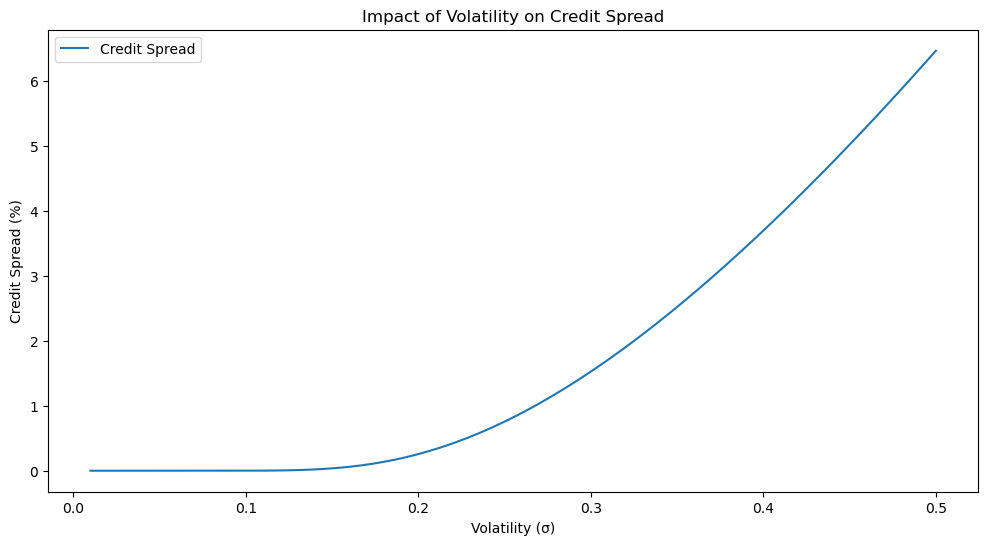

In [91]:
mp.plot_spread_vol(100,60,0,2,0)

## Impact of Time to Maturity on Credit Spread


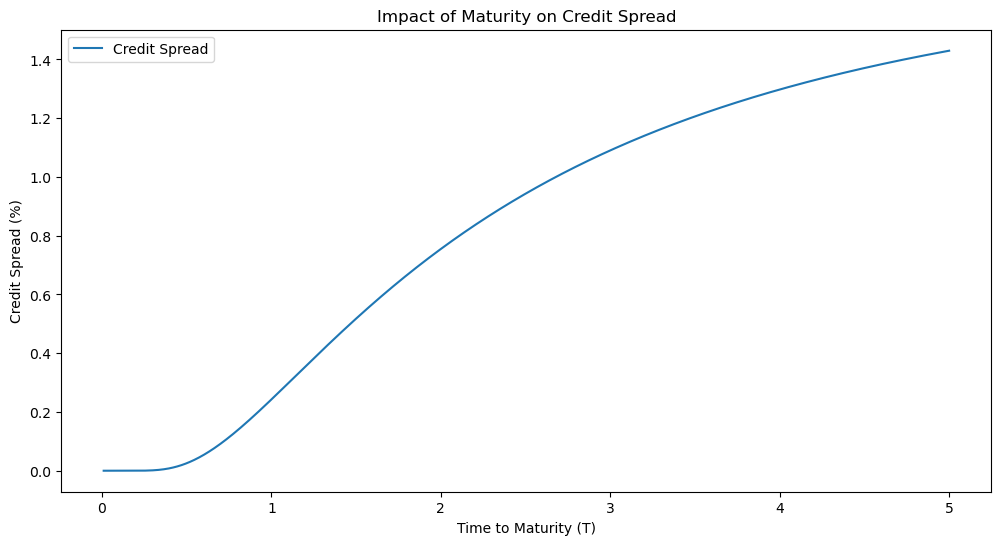

In [92]:
mp.plot_spread_time(100,60,0,2,0)

## Montecarlo simulations of the last observed day of each stock

We need a large number of simulations given the extremely low probabilities we obtain for highly capitalized firms 

In [93]:
data.loc[ric].iloc[-1,:]

Close Price                                            9.093
Shares used to calculate Diluted EPS - Total       323640100
Market Capitalization                           3706536975.0
Debt - Total                                     931124000.0
RIC                                                  BRBI.MI
Equity_Value                                    2942859429.3
Log_Returns                                        -0.003623
Rolling_Volatility                                  0.245485
Total_value                                     3873983429.3
Name: 2024-12-30 00:00:00+00:00, dtype: object

In [94]:
931124000.0 / 3837473535.041267

0.24263984923872237

In [95]:
rics_list 


['AAPL.O', 'META.O', 'BRBI.MI']

In [96]:
importlib.reload(af)
import time as time
mc_probabilities = {}
rics_paths = {}

for ric in rics_list:

    row = df_with_solutions.loc[ric].iloc[-1]
    
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    M = 1_000_000

    print('-'*100)
    print(f'{ric}\n')
    print(row)
    print('\n')
    
    merton_prob = af.default_probability(V, K, r, sigma, T , t)
    
    
    print(f'\nThe probability of default according to the Merton model is: {merton_prob}\n')
    
    mc_prob = af.monte_carlo_merton(V, K, r, sigma, T, M)
    mc_prob_anti = af.monte_carlo_merton_anti(V, K, r, sigma, T, M)


----------------------------------------------------------------------------------------------------
AAPL.O

Close Price                                                    252.2
Shares used to calculate Diluted EPS - Total             15408095000
Market Capitalization                                3463350367230.0
Debt - Total                                          107525000000.0
RIC                                                           AAPL.O
Equity_Value                                         3885921559000.0
Log_Returns                                                -0.013352
Rolling_Volatility                                          0.225923
Total_value                                          3993446559000.0
A_solution                                      3989230443444.853516
sigma_A_solution                                            0.220073
Leverage_Ratio                                              0.026954
Risk_Free_Rate                                                 

In [97]:
"""
    mc_probabilities[ric] = mc_prob
    print(f'Merton probability is: {merton_prob}')
    print(f'Monte Carlo Merton is: {mc_prob}')

    st = time.time()

    steps = 1000
    batch_size = 10_000
    mc_prob_2 = af.monte_carlo_path_batched(V, K, r, sigma, T, M, steps, batch_size)
    et = time.time()

    print(f'TIme elapsed = {et- st}')
    #rics_paths[ric] = paths
"""
    

"\n    mc_probabilities[ric] = mc_prob\n    print(f'Merton probability is: {merton_prob}')\n    print(f'Monte Carlo Merton is: {mc_prob}')\n\n    st = time.time()\n\n    steps = 1000\n    batch_size = 10_000\n    mc_prob_2 = af.monte_carlo_path_batched(V, K, r, sigma, T, M, steps, batch_size)\n    et = time.time()\n\n    print(f'TIme elapsed = {et- st}')\n    #rics_paths[ric] = paths\n"

In [98]:
# plt.figure()

# ric = rics_list[-1]
# M = 10000
# mc_prob_2, paths = af.monte_carlo_path(V, K, r, sigma, T, M, steps)
# rics_paths[ric] = paths


# paths_sing = rics_paths[ric]

# if mc_prob_2 > 0:

#     plt.axhline(np.log(V))

#     for i in range(paths_sing.shape[0]):

#         plt.plot(paths_sing[i, :], alpha = 0.2)

#     plt.axhline(np.log(K))
#     plt.title(f'A {M} simulations for {ric}')

#     plt.show()

## Ratings of S&P 500

In [99]:
ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI)',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI,Sdate=-10Y)'])
print(ratings_data.head())

ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating'])
print(ratings_data.head())

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


  Instrument        Company Common Name  Issuer Rating  Issuer Rating
0    POOL.OQ                  Pool Corp           <NA>           <NA>
1    CHRW.OQ  CH Robinson Worldwide Inc           <NA>           <NA>
2      AJG.N  Arthur J. Gallagher & Co.           <NA>           <NA>
3      CNP.N     CenterPoint Energy Inc           <NA>           <NA>
4     AMCR.N                  Amcor PLC           <NA>           <NA>
  Instrument        Company Common Name Issuer Rating
0    POOL.OQ                  Pool Corp           A1+
1    CHRW.OQ  CH Robinson Worldwide Inc           A1+
2      AJG.N  Arthur J. Gallagher & Co.          Baa2
3      CNP.N     CenterPoint Energy Inc          Baa3
4     AMCR.N                  Amcor PLC          Baa2


c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [100]:
ratings_data['Issuer Rating'].value_counts()

Issuer Rating
Baa2            51
Baa1            49
A1+             39
A1              39
                35
P-2             30
A2              25
Baa3            24
A3              20
NR              19
BBB             17
A               13
P-1             12
BBB+            11
Ba1             11
Aa3             10
BBB-             9
WR               9
A-               7
F1               6
A+               6
WD               6
Ba2              6
Discontinued     5
BB+              4
BB               4
F2               4
Aa2              4
P-3              3
Ba3              2
BB-              2
B-               2
B1               2
F3               2
AA-              2
B                2
LGD2 - 20%       1
Aaa              1
LGD4 - 68%       1
(P)Baa3          1
B+               1
LGD5 - 74%       1
LGD5 - 81%       1
(P)A2            1
AA               1
(P)Baa2          1
LGD4 - 54%       1
Name: count, dtype: Int64

In [101]:
ratings_data[ratings_data['Issuer Rating'] == 'B1']

,Instrument,Company Common Name,Issuer Rating
63,DAY.N,Dayforce Inc,B1
346,CZR.OQ,Caesars Entertainment Inc,B1
